## Perceptron Implementation with Unigram Data Representation


In [3]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import math
import random

In [2]:
# Load training data
path = "hw2data_1/reviews_tr.csv"
df_train = pd.read_csv(path)

In [3]:
# Load testing data
path2 = "hw2data_1/reviews_te.csv"
df_test = pd.read_csv(path2)

In [4]:
# Check training example format
print('Number of training example: ',len(df_train))
print(df_train.head(3))

Number of training example:  1000000
   label                                               text
0      1  first time here food tastes great good environ...
1      0  i have been craving burgers lately so i decide...
2      1  i love having a place like this in the neighbo...


In [5]:
# Feature Pruning
vocabulary_dict = {}
for text in df_train['text']:
    words = text.split()
    for word in words:
        if word not in vocabulary_dict: 
            vocabulary_dict[word] = 1
        else:
            vocabulary_dict[word] += 1
print('The number of unique words: ', len(vocabulary_dict))

low_occurrence_word_set = set()
for key, value in vocabulary_dict.items():
    if value < 100: low_occurrence_word_set.add(key) # Get rid of words with low occurrence; Can further add 'stop words' here

print('The number of words/features to exclude: ',len(low_occurrence_word_set))
print('The number of feature to consider: ', len(vocabulary_dict) - len(low_occurrence_word_set))

The number of unique words:  207429
The number of words/features to exclude:  191905
The number of feature to consider:  15524


-------

In [6]:
# Data Representation: Unigram (bag-of-words);  Disadvantage: lose the order and locality of the words
# Use hashmap to compress the data - only remember the feature whose value is not zero; Can better utilized memory and speed up dot product calculation
def data_compression(df_train):
    list_dict = []  # Contains training examples compressed with hashmap

    for index, row in df_train.iterrows():
        new_dict = {}
        words = row['text'] + ""
        words = words.split()
        for word in words:
            if word not in low_occurrence_word_set: # Feature Pruning
                if word in new_dict:
                    new_dict[word] += 1
                else:
                    new_dict[word] = 1

        if(row['label'] == 1):  # Incorporate the label with the feature vector
            new_dict['*label*'] = 1
        else: new_dict['*label*'] = -1

        new_dict['*const*'] = 1   # Lifting
        list_dict.append(new_dict)

    return list_dict

In [7]:
# Load features into a dict
start_time = time.time()
list_dict = data_compression(df_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 93.14159655570984 seconds ---


In [8]:
# Online-batch perceptron implementation
def train_unigram(list_dict):
    w = {} # Store tmp weights
    w_ret = {} # Store the average weigths
    
    # First pass
    random.shuffle(list_dict)
    for x in list_dict:
        dot_product = 0
        label = x['*label*']
        for key, value in x.items():
            if key != '*label*':
                if key in w:
                    dot_product += w[key] * x[key]
        
        if dot_product * label <= 0:
            
            for key, value in x.items():
                if key != '*label*':
                    if key in w:
                        w[key] += label * x[key]
                    else: w[key] = label * x[key]
    
    
    count = 0    # debug
    start_time = time.time()    # debug

    # Second pass
    random.shuffle(list_dict)
    w_ret = dict(w) # Initilize w_ret
    for x in list_dict:
        dot_product = 0
        label = x['*label*']
        for key, value in x.items():
            if key != '*label*':
                if key in w:
                    dot_product += w[key] * x[key]
           
        if dot_product * label <= 0:
            for key, value in x.items():
                if key != '*label*':
                    if key in w:
                        w[key] += label * x[key]
                    else: w[key] = label * x[key]
        
        # Update w_ret
        for key, value in w.items():
            if key in w_ret:
                w_ret[key] += value
            else:
                w_ret[key] = value
        
        # For debug purpose
        if count % 10000 == 0:    
            print('Current progress: ', count, end= ' ')     
            print(' time elapsed: ', time.time() - start_time)    
        count += 1    
    
    # Calculate weighted weight vector
    length = len(list_dict) + 1
    for key, value in w_ret.items():
        w_ret[key] /= length
    return w_ret
    
#     # Transfrom back to a vector
#     w_vector = [0] * (len(vocabulary_dict) + 1)
#     for key, value in w.items():
#         if key in vocabulary_dict:
#             w_vector[vocabulary_dict[key]] = value
#     w_vector[-1] = w['*const*']

In [9]:
# Test weight vector w on the given testing set
def test_unigram(df_test, w):
    dict_list_test = data_compression(df_test) # Don't really have to load this every time being called
    count = 0
    wrong = 0
    for dictionary in dict_list_test:
        count += 1
        dot_product = 0
        label = dictionary['*label*']
        for key, value in dictionary.items():
            if key in w and key != '*label*':
                dot_product += w[key] * dictionary[key]
        if dot_product * label <= 0: wrong += 1 
    return (count - wrong) / count

In [10]:
# Evaluating the performance of the classifier with different training sizes
# start = 1, end = 5 <=> training size range: 10%, 20%,...,50%
# list_dict: contains the entire training samples
# Return two lists
def test(list_dict, start = 1, end = 5):
    w_list = []
    accuracy_list = []
    for i in range(start, end + 1):
        list_dict_current_size = list_dict[:int(len(list_dict) * i * 0.1)]
        w = train_unigram(list_dict_current_size)
        w_list.append(w)
        print('Training size: ', i * 10, '%', end='')
        
        accuracy = test_unigram(df_test, w)
        accuracy_list.append(accuracy)
        print('  Accuracy: ', accuracy)
        print()
    return w_list, accuracy_list

In [78]:
w_list = []
accuracy_list = []
w_list, accuracy_list = test(list_dict)

Current progress:  0  time elapsed:  0.08100724220275879
Current progress:  10000  time elapsed:  23.473536252975464
Current progress:  20000  time elapsed:  47.14367890357971
Current progress:  30000  time elapsed:  71.18328142166138
Current progress:  40000  time elapsed:  95.21503829956055
Current progress:  50000  time elapsed:  119.33020496368408
Current progress:  60000  time elapsed:  143.57458090782166
Current progress:  70000  time elapsed:  168.09141063690186
Current progress:  80000  time elapsed:  192.85489916801453
Current progress:  90000  time elapsed:  217.46832156181335
Training size:  10 %Accuracy:  0.8841379224170784
Current progress:  0  time elapsed:  0.15601396560668945
Current progress:  10000  time elapsed:  23.64736580848694
Current progress:  20000  time elapsed:  47.74582624435425
Current progress:  30000  time elapsed:  71.96625995635986
Current progress:  40000  time elapsed:  96.21390128135681
Current progress:  50000  time elapsed:  121.00344204902649
Cur

Current progress:  340000  time elapsed:  857.2533714771271
Current progress:  350000  time elapsed:  882.4730141162872
Current progress:  360000  time elapsed:  907.5214285850525
Current progress:  370000  time elapsed:  932.5658440589905
Current progress:  380000  time elapsed:  957.6134569644928
Current progress:  390000  time elapsed:  982.5894596576691
Current progress:  400000  time elapsed:  1007.6150705814362
Current progress:  410000  time elapsed:  1032.5596687793732
Current progress:  420000  time elapsed:  1057.5258693695068
Current progress:  430000  time elapsed:  1082.494470834732
Current progress:  440000  time elapsed:  1107.4612715244293
Current progress:  450000  time elapsed:  1132.4354729652405
Current progress:  460000  time elapsed:  1157.4132742881775
Current progress:  470000  time elapsed:  1182.725130558014
Current progress:  480000  time elapsed:  1207.6961317062378
Current progress:  490000  time elapsed:  1232.6615319252014
Training size:  50 %Accuracy:  0

-----

In [11]:
# Run this block for a specific training size test
k = 1 # training size percentage e.g. 0.5 <=> 50%
list_dict_tmp = list_dict[:int(len(list_dict) * k)]

In [ ]:
# Run this block for a specific training size test
start_time = time.time()
w = train_unigram(list_dict_tmp) # Test on a smaller subset first
print("Total Traing Time: --- %s seconds ---" % (time.time() - start_time))

In [13]:
# Run this block for a specific training size test
start_time = time.time()
print(test_unigram(df_test, w))
print("Testing Time: --- %s seconds ---" % (time.time() - start_time))

0.8949900350491375
Testing Time: --- 36.29430174827576 seconds ---


In [14]:
# TOP20 Positive Words when the model has the highest accuracy
sorted(w.items(), key=lambda x: x[1], reverse = True)[:20]

[('perfection', 160.95294404705595),
 ('gem', 158.07886392113608),
 ('disappoint', 128.60505139494862),
 ('phenomenal', 126.74939825060174),
 ('heavenly', 124.75710024289975),
 ('heaven', 121.54008545991454),
 ('incredible', 119.96416003583997),
 ('perfect', 119.41774258225742),
 ('skeptical', 118.16856983143016),
 ('exceeded', 118.12423987576013),
 ('superb', 117.36995663004338),
 ('fantastic', 114.17922082077918),
 ('perfectly', 111.8997281002719),
 ('minor', 108.97752402247598),
 ('excellent', 107.68669631330368),
 ('deliciousness', 107.006903993096),
 ('hooked', 105.51402948597051),
 ('delicious', 103.88030211969787),
 ('worried', 102.35585264414736),
 ('glad', 100.17325482674518)]

In [15]:
# TOP20 Negative Words when the model has the highest accuracy
sorted(w.items(), key=lambda x: x[1], reverse = False)[:20]

[('worst', -201.71768028231972),
 ('flavorless', -194.4140695859304),
 ('mediocre', -179.92884907115092),
 ('poisoning', -177.98037401962597),
 ('underwhelming', -174.85432814567184),
 ('lacked', -174.53114246885752),
 ('inedible', -165.3230466769533),
 ('underwhelmed', -162.6978103021897),
 ('disgusting', -161.50284749715252),
 ('tasteless', -159.24835875164123),
 ('awful', -156.24327175672823),
 ('meh', -152.08522991477008),
 ('disappointing', -147.44352455647544),
 ('horrible', -147.27376672623328),
 ('potential', -146.4134005865994),
 ('hopes', -145.04209095790904),
 ('lukewarm', -143.1106488893511),
 ('ruined', -142.01343798656202),
 ('downhill', -140.9140740859259),
 ('bland', -139.99704000296)]

------------

### Final Test Results for Unigram Representation

    Training Size:   5 %  Accuracy:  0.8784088566234123
    Training Size:  10 %  Accuracy:  0.8841379224170784
    Training Size:  20 %  Accuracy:  0.8888611216973529
    Training Size:  30 %  Accuracy:  0.8900263024721825
    Training Size:  40 %  Accuracy:  0.8923316735494593
    Training Size:  50 %  Accuracy:  0.8928408544242508  Training Time: 1260.2 seconds (21 minutes)
    Training Size:  70 %  Accuracy:  0.8937936161838299
    Training Size:  80 %  Accuracy:  0.8943902637119598
    Training Size:  90 %  Accuracy:  0.8946386486598453
    Training Size: 100 %  Accuracy:  0.8949900350491375  Training Time: 2609.9 seconds (43 minutes)

### Test Result for All Representations

In [1]:
# These are the test results for plot
x = [i * 0.1 for i in range(1,11)]
y_unigram = [0.88414, 0.88886, 0.89003, 0.89233, 0.89284, 0.89348, 0.89379, 0.89439, 0.89464, 0.89499]
y_tfidf =   [0.84168,0.85292,0.86001,0.86158,0.86424,0.86728,0.86924,0.87042,0.87190,0.87350]
y_bigram =  [0.84955,0.85553,0.85388,0.86557,0.85779,0.86677,0.86808,0.87516,0.87070,0.87008]

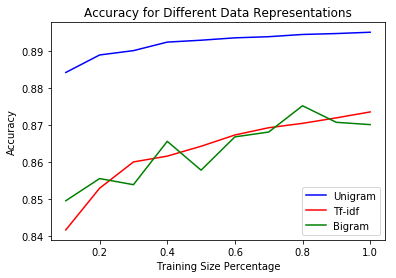

In [4]:
plt.plot(x, y_unigram, '-b', label = "Unigram")
plt.plot(x, y_tfidf, '-r', label = "Tf-idf")
plt.plot(x, y_bigram, '-g', label = "Bigram")
plt.legend()
plt.xlabel("Training Size Percentage")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Data Representations")
plt.show()

In [61]:
# TEST5: size 5%, with pruning
start_time = time.time()
print(test_unigram(df_test, w))
print("--- %s seconds ---" % (time.time() - start_time))

0.8784088566234123
--- 36.10690975189209 seconds ---


In [62]:
# TEST5: size 5%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -138.55044899102018),
 ('bland', -118.90682186356273),
 ('mediocre', -111.46507069858603),
 ('ok', -97.55382892342153),
 ('overpriced', -94.72186556268875),
 ('nothing', -92.32591348173037),
 ('unfortunately', -90.94836103277935),
 ('horrible', -87.00023999520009),
 ('okay', -84.86636267274655),
 ('meh', -80.92920141597168),
 ('dry', -77.91660166796665),
 ('disappointment', -77.07839843203136),
 ('terrible', -76.55296894062118),
 ('rude', -73.45003099938002),
 ('guess', -72.98470030599388)]

In [63]:
# TEST5: size 5%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = True)[:15]

[('delicious', 106.87676246475071),
 ('amazing', 105.24183516329673),
 ('perfect', 95.7785244295114),
 ('perfectly', 93.05735885282294),
 ('excellent', 89.25439491210176),
 ('loved', 87.13433731325374),
 ('wonderful', 85.55646887062258),
 ('fantastic', 81.12157756844863),
 ('glad', 77.1717565648687),
 ('awesome', 73.11065778684426),
 ('perfection', 71.79282414351712),
 ('yummy', 65.77378452430952),
 ('attentive', 65.19891602167957),
 ('best', 62.77302453950921),
 ('incredible', 61.44093118137637)]

In [56]:
# TEST4: size 70%, with pruning, 30 minutes
start_time = time.time()
print(test_unigram(df_test, w))
print("--- %s seconds ---" % (time.time() - start_time))

0.8937936161838299
--- 36.06127738952637 seconds ---


In [57]:
# TEST4: size 70%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -192.93664437622232),
 ('flavorless', -178.62880338742374),
 ('lacked', -178.1516912118697),
 ('mediocre', -173.96528004959993),
 ('tasteless', -169.71325183821165),
 ('underwhelmed', -155.58706058991345),
 ('awful', -152.3856751633212),
 ('disappointing', -150.11517412117982),
 ('meh', -148.56916204405422),
 ('horrible', -144.41585940591514),
 ('inedible', -143.13583694880435),
 ('bland', -142.55834348808074),
 ('underwhelming', -138.57177204032567),
 ('poisoning', -138.01465855048778),
 ('hopes', -135.53183781166027)]

In [58]:
# TEST4: size 70%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -192.93664437622232),
 ('flavorless', -178.62880338742374),
 ('lacked', -178.1516912118697),
 ('mediocre', -173.96528004959993),
 ('tasteless', -169.71325183821165),
 ('underwhelmed', -155.58706058991345),
 ('awful', -152.3856751633212),
 ('disappointing', -150.11517412117982),
 ('meh', -148.56916204405422),
 ('horrible', -144.41585940591514),
 ('inedible', -143.13583694880435),
 ('bland', -142.55834348808074),
 ('underwhelming', -138.57177204032567),
 ('poisoning', -138.01465855048778),
 ('hopes', -135.53183781166027)]

In [41]:
# TEST3: size 10%, with pruning, 6 minutes
start_time = time.time()
print(test_unigram(df_test, w))
print("--- %s seconds ---" % (time.time() - start_time))

0.8844159414223327
--- 38.1008095741272 seconds ---


In [42]:
# TEST3: size 10%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -175.8940610593894),
 ('bland', -144.00270997290028),
 ('mediocre', -140.89094109058908),
 ('disappointing', -126.93766062339377),
 ('unfortunately', -121.96344036559634),
 ('horrible', -111.5720342796572),
 ('ok', -110.81521184788153),
 ('disappointment', -105.75664243357566),
 ('terrible', -102.9160008399916),
 ('overpriced', -98.51642483575164),
 ('okay', -97.59347406525934),
 ('nothing', -95.94946050539495),
 ('meh', -95.4869951300487),
 ('awful', -94.18670813291867),
 ('lacked', -91.22361776382236)]

In [43]:
# TEST3: size 10%, with pruning
sorted(w.items(), key=lambda x: x[1], reverse = True)[:15]

[('perfect', 120.92620073799262),
 ('amazing', 109.47656523434766),
 ('perfection', 104.6861031389686),
 ('excellent', 103.27271727282726),
 ('wonderful', 102.14054859451406),
 ('delicious', 100.46476535234648),
 ('fantastic', 98.54290457095429),
 ('perfectly', 96.6631233687663),
 ('disappoint', 95.32077679223208),
 ('incredible', 93.81687183128169),
 ('outstanding', 84.86997130028699),
 ('loved', 84.54646453535464),
 ('glad', 81.13015869841301),
 ('awesome', 79.28472715272848),
 ('five', 74.54740452595475)]

In [23]:
# TEST2:Train size 20%, training time 30 minutes
start_time = time.time()
print(test_unigram(df_test, w))
print("--- %s seconds ---" % (time.time() - start_time))

0.8886018455463854
--- 34.6804678440094 seconds ---


In [24]:
# TEST2:TOP15 negative words
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -197.37132314338427),
 ('mediocre', -165.49916750416247),
 ('bland', -156.6994315028425),
 ('disappointing', -153.76591117044416),
 ('awful', -138.2646336768316),
 ('disappointment', -137.90298048509757),
 ('meh', -131.87646061769692),
 ('lacked', -128.48018259908702),
 ('horrible', -124.95228523857381),
 ('flavorless', -123.66033169834151),
 ('tasteless', -123.61867690661546),
 ('terrible', -115.26302368488157),
 ('unfortunately', -112.25176374118129),
 ('lacking', -108.7718161409193),
 ('ok', -106.65787671061645)]

In [25]:
# TEST2:TOP15 negative words
sorted(w.items(), key=lambda x: x[1], reverse = True)[:15]

[('perfection', 138.8519957400213),
 ('incredible', 132.52879235603822),
 ('disappoint', 116.25043874780626),
 ('perfect', 114.44366778166109),
 ('glad', 108.07126964365179),
 ('perfectly', 105.9279053604732),
 ('delicious', 101.83353083234584),
 ('amazing', 100.30448847755761),
 ('wonderful', 99.43891780541097),
 ('pleased', 98.85502572487138),
 ('outstanding', 98.13219933900331),
 ('gem', 98.09133954330228),
 ('excellent', 95.6563167184164),
 ('fantastic', 91.38859305703471),
 ('heaven', 87.7121864390678)]

In [37]:
# Test1: Train size 10%, training time 20 minutes
start_time = time.time()
print(test_unigram(df_test, w))
print("--- %s seconds ---" % (time.time() - start_time))

0.8849407413423632
--- 46.270057916641235 seconds ---


In [36]:
# TEST1: TOP15 negative words
sorted(w.items(), key=lambda x: x[1], reverse = False)[:15]

[('worst', -157.89968100318995),
 ('mediocre', -145.28094719052808),
 ('bland', -144.95483045169547),
 ('disappointing', -123.40432595674044),
 ('horrible', -118.47917520824792),
 ('terrible', -115.91289087109129),
 ('unfortunately', -115.58870411295887),
 ('meh', -113.02520974790252),
 ('disappointment', -104.37770622293777),
 ('ok', -103.2990470095299),
 ('awful', -100.83215167848321),
 ('overpriced', -94.40989590104098),
 ('nothing', -92.40821591784082),
 ('rude', -90.76813231867682),
 ('overcooked', -87.28211717882822)]

In [40]:
# TEST1: TOP15 Positive words
sorted(w.items(), key=lambda x: x[1], reverse = True)[:20]

[('perfect', 126.96207037929621),
 ('delicious', 108.69828301716983),
 ('amazing', 102.34909650903491),
 ('perfectly', 98.88279117208828),
 ('fantastic', 98.82754172458276),
 ('wonderful', 97.86928130718692),
 ('glad', 96.45740542594574),
 ('perfection', 95.96735032649673),
 ('excellent', 95.86153138468616),
 ('incredible', 90.26750732492675),
 ('outstanding', 87.08667913320866),
 ('awesome', 81.49759502404976),
 ('loved', 80.55550444495555),
 ('pleased', 79.57246427535725),
 ('disappoint', 79.01483985160148),
 ('juicy', 70.88135118648813),
 ('delish', 65.80271197288027),
 ('heaven', 65.45958540414595),
 ('yummy', 64.47285527144729),
 ('five', 63.20279797202028)]

In [330]:
# TF-IDF Representation
frequency = {}
for x in list_dict:
    for key, value in x.items():
        if key in frequency:
            frequency[key] += 1
        else:
            frequency[key] = 1

In [381]:
# import copy
list_dict1 = list(list_dict) # A shallow copy of list_dict
# list_dict1 = copy.deepcopy(list_dict)  #This is a deep copy but takes up a lot of memory

In [32]:
# One pass version
def train_unigram(list_dict):
    w = {} 
    
    # One pass
    random.shuffle(list_dict)
    for x in list_dict:
        dot_product = 0
        label = x['*label*']
        for key, value in x.items():
            if key != '*label*':
                if key in w:
                    dot_product += w[key] * x[key]
        
        if dot_product * label <= 0:           
            for key, value in x.items():
                if key != '*label*':
                    if key in w:
                        w[key] += label * x[key]
                    else: w[key] = label * x[key]
    return w

In [382]:
for x in list_dict1:
    for key, value in x.items():
        if key != '*label*' and key != '*const*':
            x[key] = x[key] * math.log((len(list_dict1) / frequency[key]), 10)

In [383]:
start_time = time.time()
w_tfidf = train_unigram(list_dict1, vocabulary_dict)
print("--- %s seconds ---" % (time.time() - start_time))

{}
1000000   151064


In [408]:
sorted(w_tfidf.items(), key=lambda x: x[1], reverse = False)[:10]

[('harman', -89.99999999999999),
 ('mediocre', -84.22474040199054),
 ('worst', -80.10731281700849),
 ('roum6b8yd4ykkugqcxtoug', -77.99999999999999),
 ('underwhelmed', -77.59042463214872),
 ('hopes', -71.74741110380765),
 ('disappointing', -70.60585455721528),
 ('not', -68.8592132041259),
 ('bland', -64.50013572257728),
 ('downhill', -63.45078877872636)]

In [409]:
sorted(w_tfidf.items(), key=lambda x: x[1], reverse = True)[:10]

[('n00b', 92.83507630617008),
 ('great', 91.8086860288631),
 ('delicious', 84.33372264813823),
 ('ftr', 81.41181741504607),
 ('jmc', 80.96910013008055),
 ('and', 78.32414188144158),
 ('ohfh6alqqq35niebd1exuw', 77.99999999999999),
 ('perfection', 77.70343425406247),
 ('amazing', 74.67204708243527),
 ('zfpcpbzssimrybsg9jxndw', 71.99999999999999)]

In [410]:
frequency['n00b']

13

In [411]:
def test_tfidf(df_test, w_tfidf, frequency):
    dict_list_test, dict_vocabulary_test = data_compression(df_test)
    count = 0
    wrong = 0
    for x in dict_list_test:
        for key, value in x.items():
            if key != '*label*' and key != '*const*':
                if key in frequency: x[key] = x[key] * math.log((len(dict_list_test) / frequency[key]), 10)
        
        count += 1
        dot_product = 0
        label = x['*label*']
        for key, value in x.items():
            if key in w and key != '*label*':
                dot_product += w[key] * x[key]
        if dot_product * label <= 0: wrong += 1 
    return (count - wrong) / count

In [412]:
start_time = time.time()
print(test_tfidf(df_test, w_tfidf, frequency))
print("--- %s seconds ---" % (time.time() - start_time))

0.872884
--- 283.20725202560425 seconds ---


In [ ]:
# shallow copy and deep copy

In [372]:
list1 = []
dict1 = {'a': 1, 'b': 2}
dict2 = {'f':1, 'e':2}
list1.append(dict1)
list1.append(dict2)

In [366]:
list2 = list(list1)
list2[0]['a'] = 3
print(list1)
print(list2)

[{'a': 3, 'b': 2}, {'f': 1, 'e': 2}]
[{'a': 3, 'b': 2}, {'f': 1, 'e': 2}]


In [374]:
import copy
list2 = copy.deepcopy(list1)
list2[0]['a'] = 3
print(list1)
print(list2)

[{'a': 1, 'b': 2}, {'f': 1, 'e': 2}]
[{'a': 3, 'b': 2}, {'f': 1, 'e': 2}]


In [42]:
# 

def train():
    
    X = [] # Training set feature vectors after lifting
    Y = [] # Training set labels
    w = [0] * len(X[0]) #weight vector
    w = np.array(w)

    # Need to shuffle the data
    
    # First pass
    for i in range(len(X)):
        if X[i] @ w * Y[i] <= 0: 
            w = w + Y[i] * X[i]

    w_final = np.array(w)

    # Need to shuffle the data

    
    # Second pass
    for i in range(len(X)):
        if X[i] @ w * Y[i] <= 0: 
            w = w + Y[i] * X[i]
        w_final += w

    w_final /= len(X) + 1
    
    return w_final

def test(x, w):
    if x @ w > 0: return 1
    if x @ w < 0: return 0
    else return -1  #Error

IndexError: list index out of range

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())


{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [74]:
# Problem lies in dot product: it takes so much time for two vectors with 110000+ values
list1 = [1] * 110000
list2 = [i for i in range(110000)]  
np.array(list1) @ np.array(list2)

In [314]:
# != compares the value, whereas is not compares if they are the same object
dict_test = {'*label*': 1}
for key, value in dict_test.items():
    if key != '*label*': print("haha") 